# Spectral Energy Distribution of TXS 0506+056

In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gammapy.catalog import CATALOG_REGISTRY
from gammapy.datasets import FluxPointsDataset, Datasets
from astropy import units as u

## Prepare Data

### Low energy wavelenghts

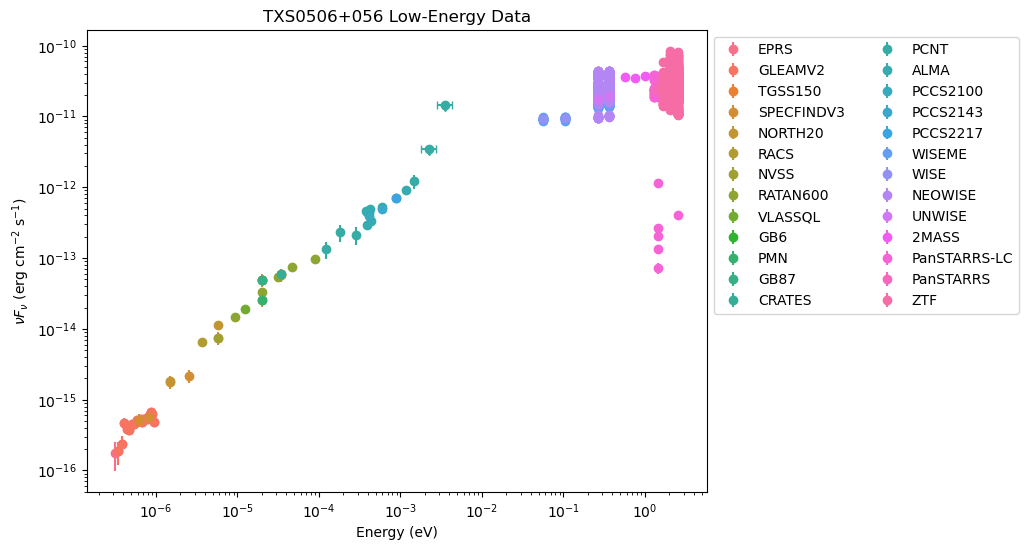

In [2]:
# Read the CSV file
df_low = pd.read_csv('TXS0506+056_low.csv')

# Use seaborn color palette for better legend colors
catalogs = df_low['catalog'].unique()
color_cycle = sns.color_palette("husl", n_colors=len(catalogs))

plt.figure(figsize=(8,6))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_low[df_low['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt='o', color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    fraction = 0.2  # 20% of the flux, for example
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.title("TXS0506+056 Low-Energy Data")
plt.show()

## SWIFT Data Own Analysis

In [3]:
# Define column names for the unfolded spectrum
column_names = ['energy', 'denergy', 'flux', 'flux_err', 'model_flux']

# Read the QDP file, fixing the deprecation warning
df_unfolded = pd.read_table('mydata3.qdp', skiprows=3, names=column_names, sep='\s+')

# Replace 'NO' values with NaN and convert columns to numeric
df_unfolded.replace('NO', np.nan, inplace=True)
df_unfolded = df_unfolded.apply(pd.to_numeric)

Text(0.5, 1.0, 'Unfolded XSPEC Spectrum of TXS0506+056')

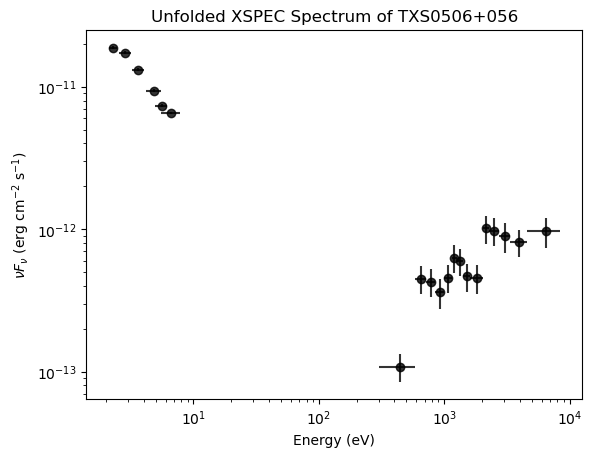

In [4]:
# Convert entire Series into Quantity objects before calling .to()
energy_Hz = df_unfolded['energy'].values * u.Hz
denergy_Hz = df_unfolded['denergy'].values * u.Hz

# Convert Hz -> eV
energy_eV = energy_Hz.to(u.eV, equivalencies=u.spectral())
denergy_eV = denergy_Hz.to(u.eV, equivalencies=u.spectral())

# Plot the unfolded XSPEC spectrum
plt.subplot()

plt.errorbar(
    energy_eV.value,
    df_unfolded['flux'],
    xerr=denergy_eV.value,
    yerr=df_unfolded['flux_err'],
    fmt='o',
    color='black',
    alpha=0.8
)

# Customize plot
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
plt.title('Unfolded XSPEC Spectrum of TXS0506+056')

### Gamma-ray data from Fermi catalogs

In [5]:
#Getting data from Fermi catalogs
catalog_4fgl = CATALOG_REGISTRY.get_cls("4fgl")()
catalog_3fhl = CATALOG_REGISTRY.get_cls("3fhl")()

source_fermi_4fgl = catalog_4fgl["4FGL J0509.4+0542"]
source_fermi_3fhl = catalog_3fhl["3FHL J0509.4+0542"]

dataset_4fgl = FluxPointsDataset(data=source_fermi_4fgl.flux_points, name="Fermi 4FGL-DR4")
dataset_4fgl.data.to_table(sed_type="dnde", formatted=True)

dataset_3fhl = FluxPointsDataset(data=source_fermi_3fhl.flux_points, name="Fermi 3FHL")
dataset_3fhl.data.to_table(sed_type="dnde", formatted=True)

e_ref,e_min,e_max,dnde,dnde_errp,dnde_errn,dnde_ul,sqrt_ts,is_ul
GeV,GeV,GeV,1 / (GeV s cm2),1 / (GeV s cm2),1 / (GeV s cm2),1 / (GeV s cm2),,
float64,float64,float64,float64,float64,float64,float64,float32,bool
14.142,10.000,20.000,2.270e-11,3.150e-12,2.855e-12,nan,19.986,False
31.623,20.000,50.000,4.094e-12,7.532e-13,6.723e-13,nan,16.386,False
86.603,50.000,150.000,3.535e-13,1.238e-13,9.950e-14,nan,8.991,False
273.861,150.000,500.000,1.701e-14,1.725e-14,1.059e-14,nan,3.026,False
1000.000,500.000,2000.000,3.266e-28,3.781e-15,nan,7.561e-15,0.000,True


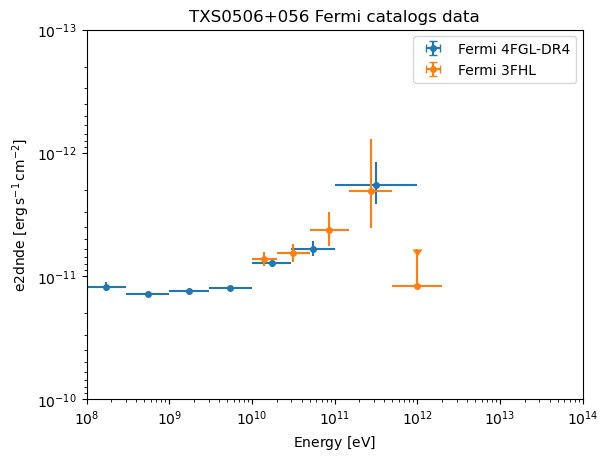

In [6]:
datasets = Datasets([dataset_4fgl, dataset_3fhl])

ax = plt.subplot()
ax.xaxis.set_units(u.Unit("eV"))

kwargs = {"ax": ax, "sed_type": "e2dnde"}

for d in datasets:
    d.data.plot(label=d.name, **kwargs)

energy_bounds = [0.0001, 100] * u.TeV 
ax.set_ylim(1e-10, 1e-13)
ax.set_xlim(energy_bounds)
plt.title('TXS0506+056 Fermi catalogs data')
ax.legend()
plt.show()

## SED with own SWIFT data

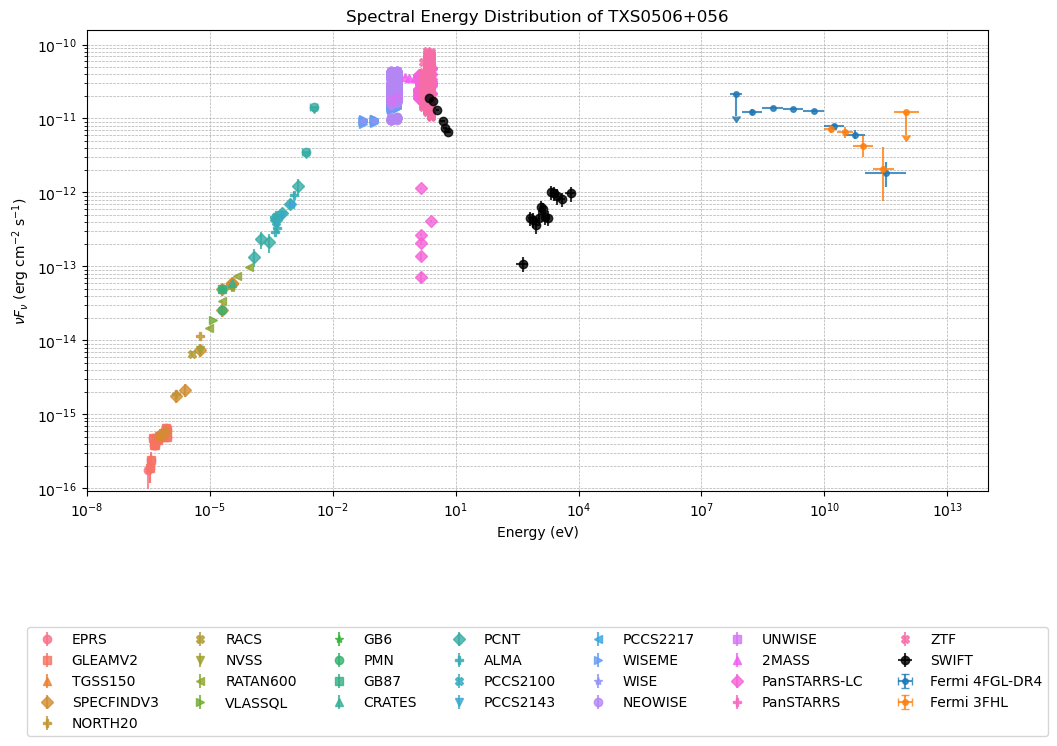

In [7]:
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*']  # Add more if needed

# Create a combined plot
fig, ax = plt.subplots(figsize=(11, 8))
# Set x-axis units to eV so that the Fermi plot (which uses eV) aligns correctly
ax.xaxis.set_units(u.Unit("eV"))

# Plot low-energy data (detections and upper limits)
for i, cat in enumerate(catalogs):
    df_cat = df_low[df_low['catalog'] == cat]
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    color = color_cycle[i % len(color_cycle)]
    marker = markers[i % len(markers)]
    
    # Plot detections
    if not df_cat[det_mask].empty:
        ax.errorbar(df_cat.loc[det_mask, 'frequency'],
                    df_cat.loc[det_mask, 'flux'],
                    yerr=df_cat.loc[det_mask, 'flux_err'],
                    fmt=marker, color=color, label=f'{cat}', alpha=0.8)
    
    # Plot upper limits
    fraction = 0.2  # 20% of the flux, for example
    if not df_cat[ul_mask].empty:
        ax.errorbar(df_cat.loc[ul_mask, 'frequency'],
                    df_cat.loc[ul_mask, 'flux'],
                    yerr=df_cat.loc[ul_mask, 'flux_err'],
                    xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                    capsize=3,
                    fmt='o', color=color, uplims=True, alpha=0.8)

# Plot SWIFT unfolded spectrum data
ax.errorbar(energy_eV.value, df_unfolded['flux'],
            xerr=denergy_eV.value, yerr=df_unfolded['flux_err'],
            fmt='o', color='black', alpha=0.8, label='SWIFT')

# Plot Fermi data using the same kwargs as in your standalone Fermi plot
kwargs = {"ax": ax, "sed_type": "e2dnde"}
for d in datasets:
    d.data.plot(label=d.name, **kwargs, alpha=0.8)

# Adjust axis limits to cover the full energy range
ax.set_xlim(1e-8, 1e14)

# Set labels and title
ax.set_xlabel('Energy (eV)')
ax.set_ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
ax.set_title('Spectral Energy Distribution of TXS0506+056')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.28), ncol=7)

plt.tight_layout()
plt.show()

## SED with own SWIFT data alongside archival data

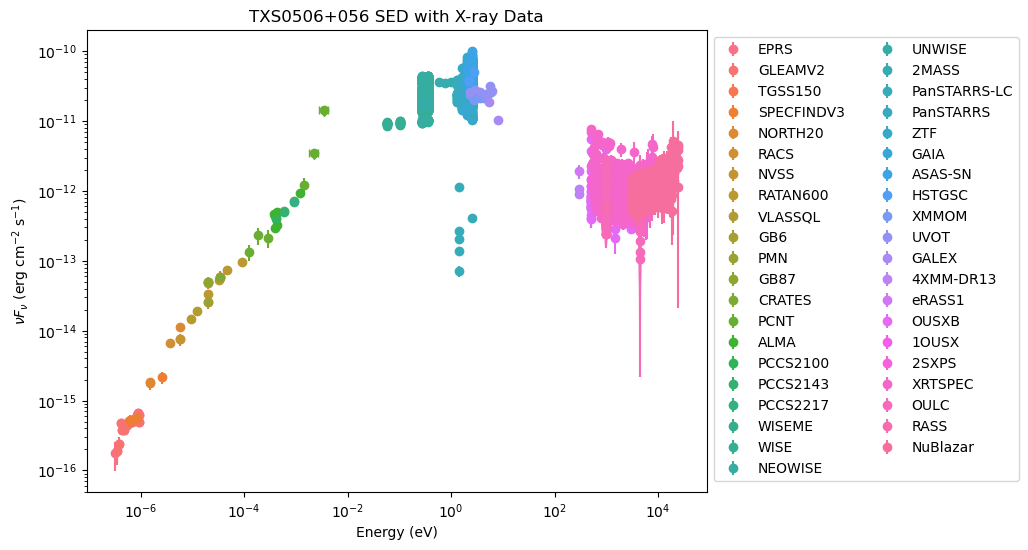

In [8]:
# Read the CSV file
df_x = pd.read_csv('TXS0506+056_xray.csv')

# Use seaborn color palette for better legend colors
catalogs = df_x['catalog'].unique()
color_cycle = sns.color_palette("husl", n_colors=len(catalogs))

plt.figure(figsize=(8,6))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_x[df_x['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt='o', color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
plt.title("TXS0506+056 SED with X-ray Data")
plt.show()

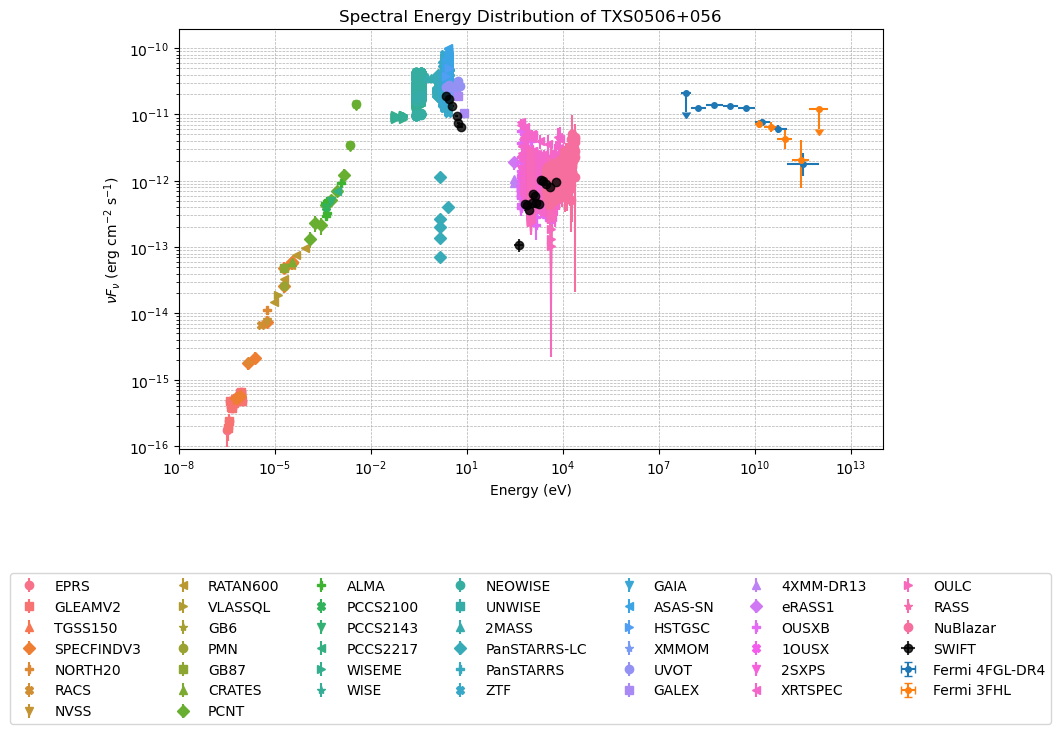

In [9]:
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*']  # Add more if needed

# Create a combined plot
fig, ax = plt.subplots(figsize=(10, 8))
# Set x-axis units to eV so that the Fermi plot (which uses eV) aligns correctly
ax.xaxis.set_units(u.Unit("eV"))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_x[df_x['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    marker = markers[i % len(markers)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt=marker, color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

# Plot SWIFT unfolded spectrum data
ax.errorbar(energy_eV.value, df_unfolded['flux'],
            xerr=denergy_eV.value, yerr=df_unfolded['flux_err'],
            fmt='o', color='black', alpha=0.8, label='SWIFT')

# Plot Fermi data using the same kwargs as in your standalone Fermi plot
kwargs = {"ax": ax, "sed_type": "e2dnde"}
for d in datasets:
    d.data.plot(label=d.name, **kwargs)
    
# Adjust axis limits to cover the full energy range
ax.set_xlim(1e-8, 1e14)

# Set labels and title
ax.set_xlabel('Energy (eV)')
ax.set_ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
ax.set_title('Spectral Energy Distribution of TXS0506+056')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.28), ncol=7)

plt.tight_layout()
plt.show()

## Comparison SEDs

### Markarian Multiwavelength Data Center

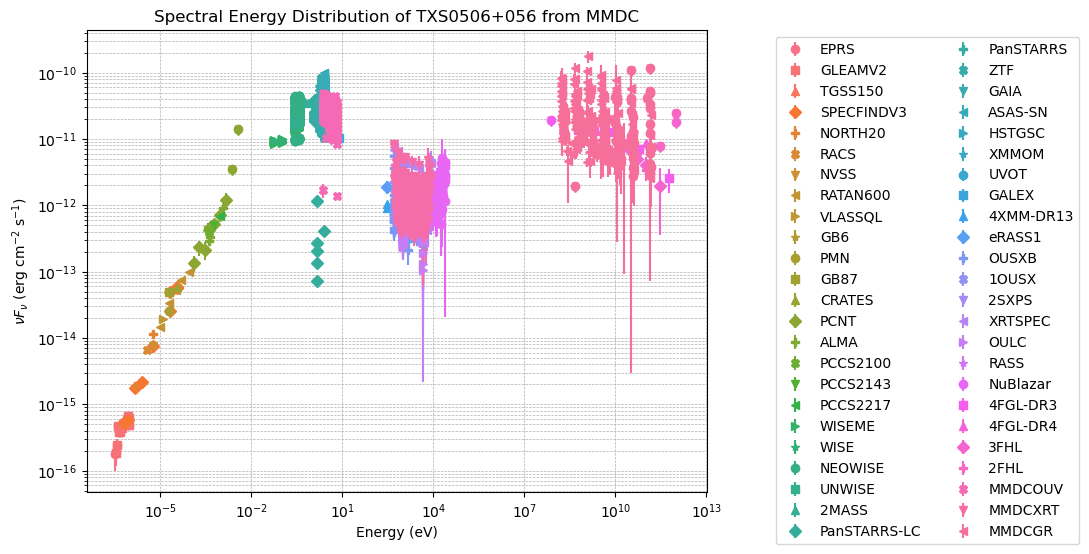

In [10]:
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*']  # Add more if needed

# Read the CSV file
df_low = pd.read_csv('TXS0506+056_complete.csv')

# Use seaborn color palette for better legend colors
catalogs = df_low['catalog'].unique()
color_cycle = sns.color_palette("husl", n_colors=len(catalogs))

plt.figure(figsize=(8,6))

# Loop through each catalog and plot its data
for i, cat in enumerate(catalogs):
    df_cat = df_low[df_low['catalog'] == cat]
    
    # Define upper limits: assuming that if 'flag' contains 'UL' (case insensitive), it's an upper limit.
    ul_mask = df_cat['flag'].str.contains('UL', case=False, na=False)
    det_mask = ~ul_mask
    
    # Get a color for this catalog from the cycle
    color = color_cycle[i % len(color_cycle)]
    marker = markers[i % len(markers)]
    
    # Plot detections with error bars
    if df_cat.loc[det_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[det_mask, 'frequency'], 
                     df_cat.loc[det_mask, 'flux'],
                     yerr=df_cat.loc[det_mask, 'flux_err'],
                     fmt=marker, color=color, label=f'{cat}')
    
    # Plot upper limits with a downward arrow marker and using uplims=True
    fraction = 0.2  # 20% of the flux, for example
    if df_cat.loc[ul_mask].shape[0] > 0:
        plt.errorbar(df_cat.loc[ul_mask, 'frequency'], 
                     df_cat.loc[ul_mask, 'flux'],
                     yerr=df_cat.loc[ul_mask, 'flux_err'],
                     xerr=fraction*df_cat.loc[ul_mask, 'frequency'],
                     capsize=3,
                     fmt='o', color=color, uplims=True)

plt.xlabel('Energy (eV)')
plt.ylabel(r'$\nu F_{\nu}$ (erg cm$^{-2}$ s$^{-1}$)')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1), ncol=2)
plt.title("Spectral Energy Distribution of TXS0506+056 from MMDC")
plt.show()

### SED Builder

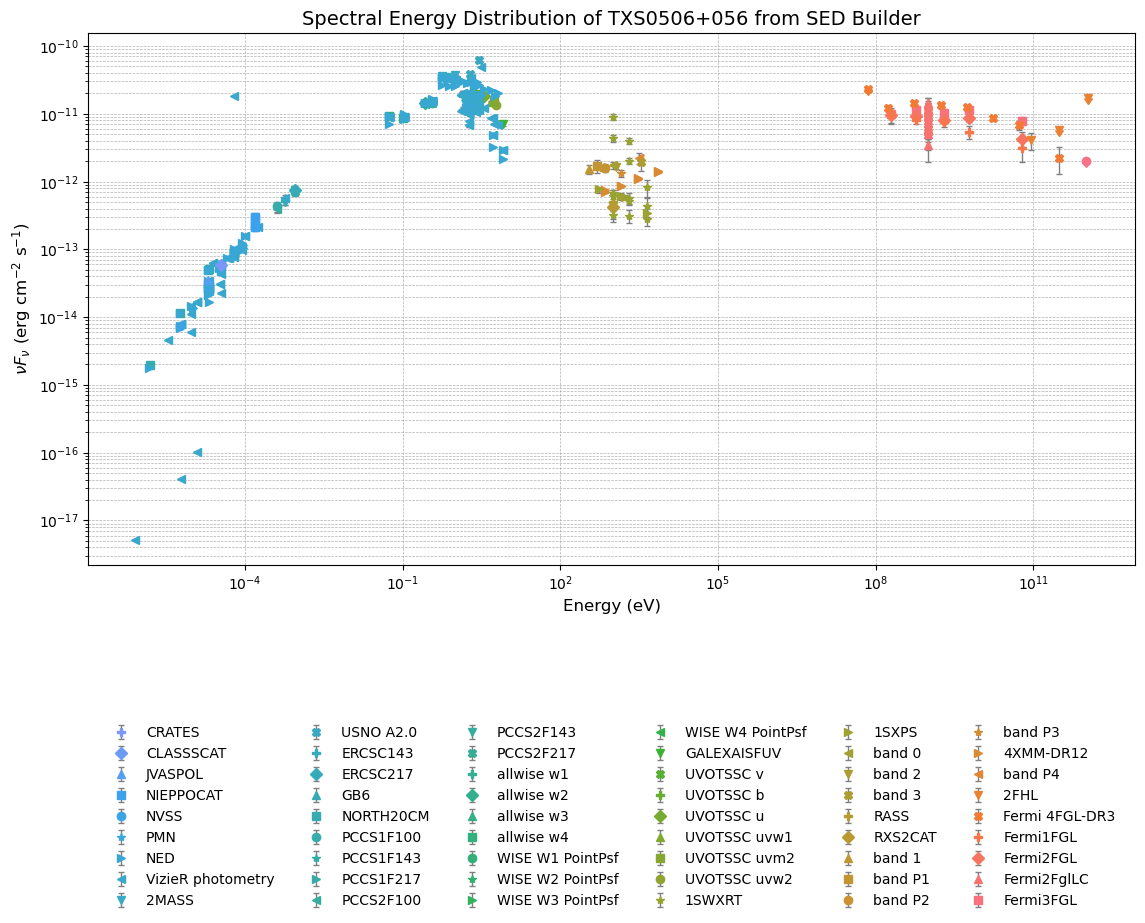

In [11]:
# Define marker styles and color palette
markers = ['o', 's', '^', 'D', 'P', 'X', 'v', '<', '>', '*']
palette = sns.color_palette("husl", 76)

# Load the data file
file_path = 'TXS0506056_Builder.txt'

# Read the file and skip the header lines
with open(file_path, 'r') as f:
    lines = f.readlines()

# Data containers
data = []
upper_limit_data = []
dataset_labels = []
label_color_map = {}
label_marker_map = {}

current_label = None
color_index = 0
marker_index = 0

# Parse the file
for line in lines:
    if line.startswith('#'):
        if 'id' in line:
            current_label = line.split('(')[0].strip().replace('#', '').strip()
            if current_label not in dataset_labels:
                dataset_labels.append(current_label)
                label_color_map[current_label] = palette[color_index % len(palette)]
                label_marker_map[current_label] = markers[marker_index % len(markers)]
                color_index += 1
                marker_index += 1
        continue

    parts = line.split()
    if len(parts) >= 6:
        try:
            energy = float(parts[0])
            flux = float(parts[2])
            flux_error = float(parts[3])
            if 'UPPER LIMIT' in line:
                upper_limit_data.append([energy, flux, flux_error, current_label])
            else:
                data.append([energy, flux, flux_error, current_label])
        except ValueError:
            continue

# Convert to DataFrames
df = pd.DataFrame(data, columns=['Energy', 'Flux', 'Flux_Error', 'Dataset'])
upper_limit_df = pd.DataFrame(upper_limit_data, columns=['Energy', 'Flux', 'Flux_Error', 'Dataset'])

# Plotting
plt.figure(figsize=(12,10))

# Plot detections
for dataset in df['Dataset'].unique():
    subset = df[df['Dataset'] == dataset]
    plt.errorbar(subset['Energy'], subset['Flux'], yerr=subset['Flux_Error'],
                 fmt=label_marker_map[dataset], label=dataset,
                 ecolor='gray', elinewidth=1, capsize=2,
                 color=label_color_map[dataset])

# Plot upper limits
for dataset in upper_limit_df['Dataset'].unique():
    subset = upper_limit_df[upper_limit_df['Dataset'] == dataset]
    plt.errorbar(subset['Energy'], subset['Flux'], yerr=subset['Flux_Error'],
                 fmt=label_marker_map[dataset], uplims=True,
                 color=label_color_map[dataset], label=None)

# Axis settings
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (eV)', fontsize=12)
plt.ylabel(r'$\nu F_\nu$ (erg cm$^{-2}$ s$^{-1}$)', fontsize=12)
plt.title('Spectral Energy Distribution of TXS0506+056 from SED Builder', fontsize=14)

# Legend settings
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1], loc='upper center',
           bbox_to_anchor=(0.5, -0.28), ncol=6, frameon=False)

plt.tight_layout()
plt.show()
